In [ ]:
from src.models import Exponential_Model
from src.criterion import right_censored
from src.load_data import load_datasets
from src.utils import train

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter

from tqdm import tqdm

In [61]:
dataset_train,dataset_test = load_datasets("TRACE",test_size=0.2)

In [62]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1
hidden_dim = [10]
batch_size = 32
print_every = 50
lr = 1e-5

In [63]:
dataloader_train = DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=batch_size,shuffle=False)

dataset_train.tensors[0].shape

torch.Size([1502, 10])

In [64]:
clf = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dim,output_dim=output_dim)

optimizer = Adam(clf.parameters(),lr=1e-3)
criterion = right_censored

In [65]:
epochs,train_loss = train(model=clf,dataloader_train=dataloader_train,optimizer=optimizer,criterion=criterion,print_every=print_every,epochs=200)

Epoch 100, LL=2049.148
Epoch 200, LL=2039.788
Epoch 300, LL=2039.666


KeyboardInterrupt: 

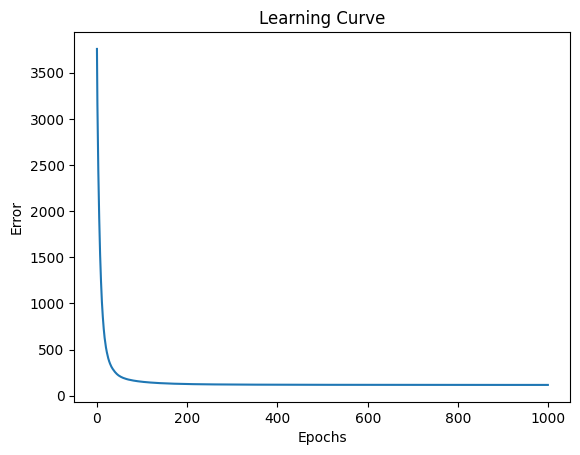

In [66]:
plt.plot(epochs,train_loss)
plt.ylabel("Error"); plt.xlabel("Epochs")
plt.title("Learning Curve")
plt.show()

In [67]:
dataloader_train.dataset.tensors[0]

tensor([[-0.9555,  0.2688,  0.6592,  ..., -0.3537,  0.2811, -0.2811],
        [ 0.9898, -1.2838,  0.6592,  ..., -0.3537,  0.2811, -0.2811],
        [ 1.4761, -0.3613,  0.6592,  ..., -0.3537,  0.2811, -0.2811],
        ...,
        [-0.7123, -1.3922,  0.6592,  ..., -0.3537, -3.5573,  3.5573],
        [-0.9555,  1.3768, -1.5169,  ..., -0.3537,  0.2811, -0.2811],
        [-1.9281, -0.1058,  0.6592,  ..., -0.3537,  0.2811, -0.2811]])

Text(0.5, 1.0, 'Population Survival Curves')

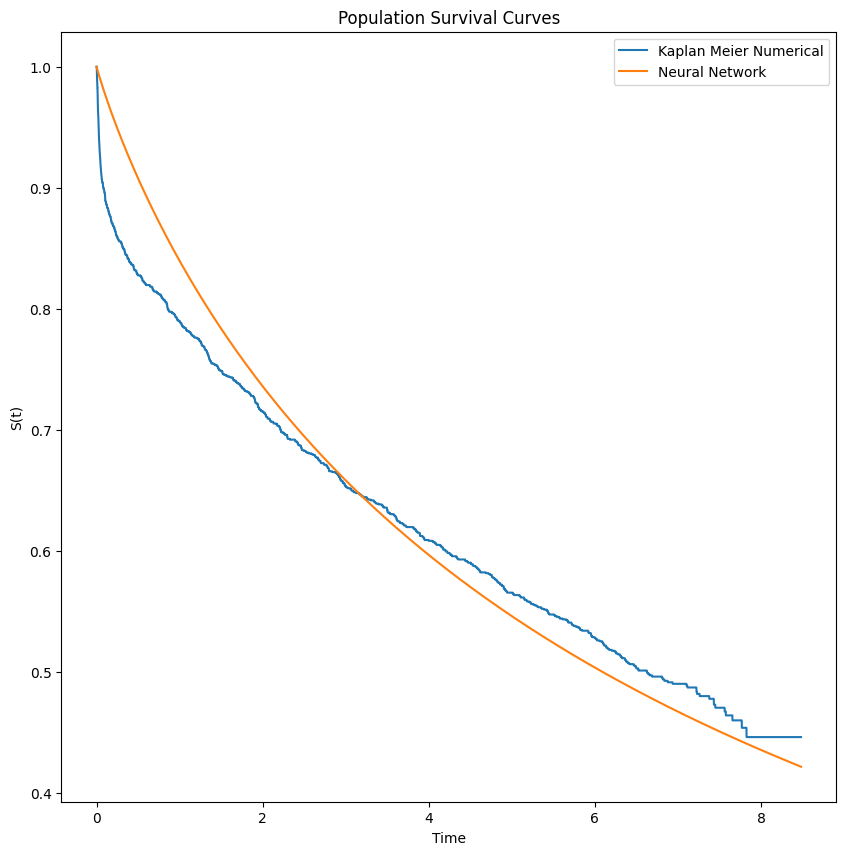

In [68]:
X,T,E = dataloader_train.dataset.tensors
t = torch.linspace(0,T.max(),10000)

St_given_x = clf.survival_qdf(X,t)

kmf = KaplanMeierFitter()
kmf.fit(durations=T,event_observed=E)
St_kmf = kSt_kmf = kmf.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_given_x.mean(0))
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network"])
plt.title("Population Survival Curves")

In [69]:
St_given_x.shape

torch.Size([1502, 10000])

In [ ]:
plt.figure(figsize=(10,10))
for Sti in tqdm(St_given_x[:100]):
    plt.plot(t,Sti)
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.title("Individual Survival Curves Train")

 53%|█████▎    | 53/100 [00:15<00:15,  3.10it/s]

In [ ]:
X,T,E = dataloader_test.dataset.tensors
t = torch.linspace(0,T.max(),10000)

St_given_x = clf.survival_qdf(X,t)

kmf = KaplanMeierFitter()
kmf.fit(durations=T,event_observed=E)
St_kmf = kSt_kmf = kmf.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_given_x.mean(0))
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network"])
plt.title("Population Survival Curves Test")